# Misconfiguration detection framework
The misconfiguration detection framework adopted in this project is inspired by the research paper ['Synthesizing Configuration File Specifications with Association Rule Learning'](https://www.cs.yale.edu/homes/zhai-ennan/configv-oopsla17.pdf#cite.santolucitoCAV). Association rule learning is a method to discover frequently occurring patterns or associations between variables in a dataset. In association rule learning, support and confidence are two metrics widely used to filter the proposed rules. Support is the percentage of times that the keywords in the proposed rule have been seen in the training configuration files. Confidence is the percentage of times the proposed rule has held true over the training configuration files.

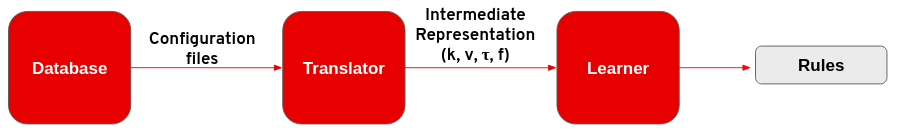

In [1]:
from IPython.display import Image
Image('images/framework.png')

As you can see in the above image, misconfiguration detection framework has two important modules: translator and learner. <br>
- **Translator**: Translator works as a parser, translator converts raw configuration files into an intermediate representation which generally has a format of key, value, data type, frequency (k, v, τ, f) <br>
- **Learner**:: Learner discovers frequently occurring patterns or associations between keywords in configuration files to derive rules. <br>

# In this notebook, our objective is to find data type errors.
Many system failure issues are caused by assigning incorrect data type values to a keyword. In this method, for each key, we match the data type of target with the data type information inferred from the training set. An error is reported if the matching fails.

## Data type error framework
Following is the example of a data type error detection framework

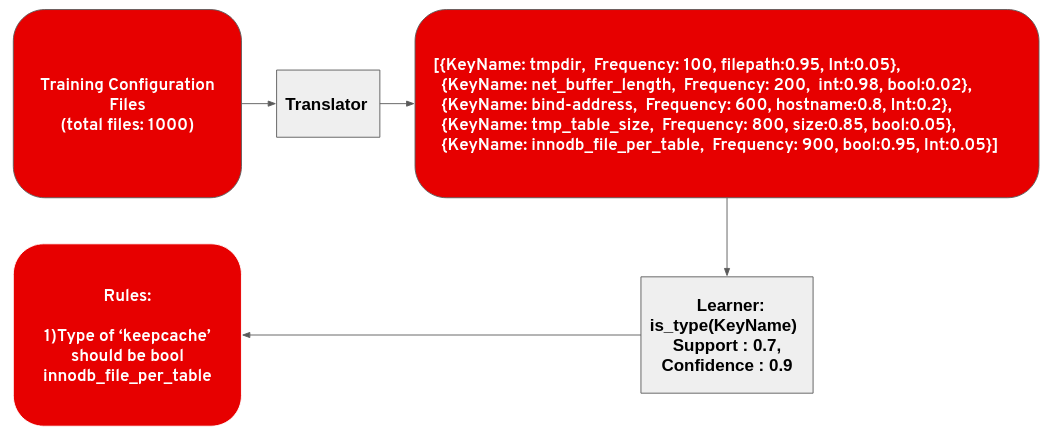

In [2]:
Image('images/type_error_framework.png')

Steps for data type error detection <br>
1) Translator parses the configuration files, determines the data type of values, and aggregate results for each key. <br>
2) Learner proposes rules by assigning every possible datatype to each keyword in configuration files. .Then filter proposed rules using support and confidence. <br>


In this notebook, we are finding data type errors in mysql.conf files. Dataset used in this notebook is publically available on the [Github](https://github.com/tianyin/configuration_datasets).
## Data type errors in mysql.cnf files


In [3]:
import os
import json
import pandas as pd
import numpy as np
from itertools import combinations
import nltk
import re
from insights.tests import context_wrap
from insights.core import IniConfigFile
from collections import defaultdict

In [4]:
# Below function parses all the configuration files based on ini type configuration files. 
class MyConfig(IniConfigFile):
    """A class specifically for reading configuration files in 'ini' format.

        The input file format supported by this class is::
           [section 1]
           key = value
           ; comment
           # comment
           [section 2]
           key with spaces = value string
           [section 3]
           # Must implement parse_content in child class
           # and pass allow_no_value=True to parent class
           # to enable keys with no values
           key_with_no_value
    """
    def parse_content(self, content, allow_no_value=True):
        """Parses content of the config file.
        """
        super(MyConfig, self).parse_content(content, allow_no_value=allow_no_value)
        
        
def get_typos(key_freq, confidence_t=0.9, typo_limit=2):
    """This function finds typos based on keyword frequencies.

    We find similar words and filter the results based on the confidence threshold.

    Parameters
    ----------
    key_freq : dictionary 
            Frequency of keyword in configuration files.
    confidence_t : float, default 0.9
            confidence threshold for spell check
    typo_limit : int, default 2
            The number of typos allowed. We calculate typos using edit distance
            For every ten characrters, we increase this argument by 1

    Returns
    ----------
    spell_errors: dictionary
            key in the dictionary is a misspelled keyword, and value is the correct version of a keyword
    """
    spell_errors = {}
    for i, j in combinations(key_freq.keys(), r=2):
        # Calculated similarity between keyword using Levenshtein distance.
        if nltk.edit_distance(i, j) >= min(len(i), len(j))//10+typo_limit:
            continue
        if key_freq[i] >= key_freq[j]:
            if key_freq[i]/(key_freq[i] + key_freq[j]) > confidence_t:
                spell_errors[j] = i
        else:
            if key_freq[j]/(key_freq[i] + key_freq[j]) > confidence_t:           
                spell_errors[i] = j
    return spell_errors

# Create_KeyValue_df function takes input as a folder path and creates a list of dictionaries as output 
def create_keyvalue_df(data_dir, fixed_typos=True):
    """This function creates a list of dictionaries as output for a set of configuration files.

    We parse and convert each configuration file into a dictionary format. 
    and append all this dictionary into a list

    Parameters
    ----------
    folder_path : string
            folder path of the configuration files.
    fixed_typos : bool, default True
            If True, fixed typos in configuration files.

    Returns
    ----------
    dict_list: list of dictionaries
            list where each element is a dictionary of a configuration file.
    """
    File_Configs = []
    parse_errors = 0
    errorconfigs = []
    for filename in os.listdir(data_dir):
        with open(os.path.join(data_dir, filename), 'r') as f: 
        #print(f.read())
            try:
                File_Configs.append(MyConfig(context_wrap(f.read())))
            except:
                parse_errors += 1
                errorconfigs.append(f.read())
                File_Configs.append(None)

    File_Configs = list(filter(None, File_Configs))

    ## Create dictionary from the configs column 
    dict_list = []
    for i in range(len(File_Configs)):
        cfgs = {}
        if len(File_Configs[i].defaults())>0:
            cfgs.update(currdict)
        for section in File_Configs[i].sections():
            currdict = File_Configs[i].items(section)
            cfgs.update(currdict)
        dict_list.append(cfgs)
        
    if fixed_typos:
        ## Fixed typos
        ## Create dataframe
        config_df = pd.DataFrame(dict_list)
        ## Find count of each key
        key_dict = config_df.count().to_dict()
        ## get typos based on frequncy of keys
        key_changes = get_typos(key_dict)
        ## Fix typos
        for dict_i in dict_list:
            for key in dict_i.copy():
                if key in key_changes:
                    dict_i[key_changes[key]] = dict_i.pop(key)

    
    return dict_list

### Finding data type from the given value

 We used a set of heuristics to infer the predefined data types from the given value. Our framework detects the bool, size, int, hostname/IP address,  file path, filename, URI, string data types. <br>

The following function takes the value of a keyword as input and infers the data type. <br>

In [5]:
import re
import math

## array for boolean
bool_arr = ['on', 'off', 'true', 'false']

def find_type(value):
    """This function infers the data type of the input argument.
    
    Parameters
    ----------
    value : 
            value for which we want to find data type

    Returns
    ----------
    datatype: 
            data type of the given input argumnet
    """
    value = value.replace("'", "")
    value = value.replace('"', "")
    if (value.lower() == 'nan') or (value.lower() == 'none') or len(value)==0:
        datatype = None 
    elif value.lower() in bool_arr:
        datatype = 'bool'
    elif value=='0' or value=='1':
        datatype = '0||1'
    elif re.search(r'^((25[0-5]|2[0-4]\d|[01]?\d\d?)\.(25[0-5]|2[0-4]\d|[01]?\d\d?)\.(25[0-5]|2[0-4]\d|[01]?\d\d?)\.(25[0-5]|2[0-4]\d|[01]?\d\d?)(,\n|,?))*$', value):
        datatype = 'ip_address/hostname'
    elif re.search(r'^\s*(?:(?:\w+(?:-+\w+)*\.)+\w+(.*[a-zA-Z].*))\s*(?:,\s*(?:(?:\w+(?:-+\w+)*\.)+\w+(.*[a-zA-Z].*))\s*)*$', value):
        datatype = 'ip_address/hostname'
    elif re.search(r'^\w+:\/\/[^\s]+', value):
        datatype = 'uri'
    elif re.search(r'^[a-zA-Z0-9_\-\*\&\:/\\]*(/|\\)*\.[a-zA-Z]*$', value):
        datatype = 'filename||filepath+filename'
    elif re.search(r'^[a-zA-Z0-9_\-\*\&\:]*/[^.:]*$', value):
        datatype = 'filepath'
    elif re.search(r'^[\d ]*(k|m|g|kb|mb|gb)$', value.lower()):
        datatype = 'size'
    elif value.isnumeric():
        datatype = 'int'
    else:
        datatype = 'string'
    
    return datatype

The following function takes the configuration files as input and infers the probabilistic data type for each key.

In [6]:
def create_intermediate(config_df):
    """This function takes the configuration files as input and infers the probabilistic data type for each key.
    
    Parameters
    ----------
    config_df : pandas Dataframe
            pandas Dataframe where each row corresponding to a configuration file.

    Returns
    ----------
    datatype: pandas Dataframe
            pandas Dataframe where each row is a probabilistic data type for a key.
    """

    # Below we calculated frequencies of different data types for each key.
    dict_list = []
    for column in config_df:
        my_dict = defaultdict(int)
        my_dict['key_name'] = column
        for i in config_df[column].tolist():
            i = str(i)
            datatype = find_type(i)
            my_dict[datatype] += 1
        dict_list.append(my_dict)
    
    # Finding frequency of each key
    datatype = pd.DataFrame(dict_list)
    datatype['frequency'] = datatype[datatype.columns[~datatype.columns.isin(['key_name', None])]].sum(axis=1)

    # We converted frequencies of data types into probabilities. 
    # We divided frequency by total nonnull entries to calculate the probability.
    datatype[datatype.columns[~datatype.columns.isin(['key_name', 'frequency', None])]] = datatype[datatype.columns[~datatype.columns.isin(['key_name', 'frequency', None])]].div(datatype[datatype.columns[~datatype.columns.isin(['key_name', 'frequency', None])]].sum(axis=1), axis=0)
    datatype = datatype.drop([None], axis=1, errors='ignore')

    # The data type for each keyword is inferred based on maximum probability
    datatype['datatype'] = datatype.drop(['key_name', 'frequency'], axis=1, errors='ignore').idxmax(axis=1)

    # 0||1 are also an integer. Hence, whenever data type is int we are assigning the same probability to 0||1
    datatype['0||1_n'] = np.where(datatype['datatype'] == 'int', datatype['int'].replace(np.nan, 0)+datatype['0||1'].replace(np.nan, 0), datatype['0||1'])
    datatype['int_n'] = np.where(datatype['datatype'] == 'int', datatype['int'].replace(np.nan, 0)+datatype['0||1'].replace(np.nan, 0), datatype['int'])
    datatype['0||1'] = datatype['0||1_n']
    datatype['int'] = datatype['int_n']
    datatype.drop(['0||1_n', 'int_n'], axis=1, inplace=True)

    # 0||1 are also an boolean. Hence, whenever data type is bool we are assigning the same probability to 0||1
    datatype['0||1_n'] = np.where(datatype['datatype'] == 'bool', datatype['bool'].replace(np.nan, 0)+datatype['0||1'].replace(np.nan, 0), datatype['0||1'])
    datatype['bool_n'] = np.where(datatype['datatype'] == 'bool', datatype['bool'].replace(np.nan, 0)+datatype['0||1'].replace(np.nan, 0), datatype['bool'])
    datatype['0||1'] = datatype['0||1_n']
    datatype['bool'] = datatype['bool_n']
    datatype.drop(['0||1_n', 'bool_n'], axis=1, inplace=True)
    
    # int is also an size. Hence, whenever data type is size we are assigning the same probability to int
    datatype['int_n'] = np.where(datatype['datatype'] == 'size', datatype['size'].replace(np.nan, 0)+datatype['int'].replace(np.nan, 0), datatype['int'])
    datatype['size_n'] = np.where(datatype['datatype'] == 'size', datatype['size'].replace(np.nan, 0)+datatype['int'].replace(np.nan, 0), datatype['size'])
    datatype['int'] = datatype['int_n']
    datatype['size'] = datatype['size_n']
    datatype.drop(['int_n', 'size_n'], axis=1, inplace=True)
    
    return datatype

#### The following cell work as a translator; translator parses the configuration files, determines the data type of values, and aggregate results for each key.

In [7]:
data_dir = 'configfiles/mysql/v-5.x'
dict_list = create_keyvalue_df(data_dir, fixed_typos=False)
config_df = pd.DataFrame(dict_list)
config_df = config_df.dropna(axis=1, how='all')
intermediate_representation = create_intermediate(config_df)
total_files = len(dict_list)

#### The following cell works as a learner and filters the proposed rules using support and confidence.

In [8]:
def create_type_rule(datatype, total_files, confidence_t=0.9, support_t=0.1):
    """This function works as a learner and filters the proposed data type rules using support and confidence.
    
    Parameters
    ----------
    datatype : pandas Dataframe
            pandas Dataframe where each row corresponding to a configuration file.
    total_files : int
            total number of configuration files.
    confidence_t : float, default 0.9
            confidence threshold for data type errors.
    support_t : float, default 0.1
            support threshold for data type errors.

    Returns
    ----------
    list_datatype_dict: list
            list of dictionaries which contains two keys,
            The first keys are for key_name in the configuration file; Second keys are the data type of the given key.
    """

    # We filter out all the rules with support below the threshold
    datatype = datatype[datatype['frequency']/total_files>support_t]
    datatype = datatype.drop(['frequency'], axis=1, errors='ignore')
    
    # We filter out all the rules with confidence below the threshold
    datatype = datatype[datatype.drop(['key_name','datatype'], axis=1, errors='ignore').max(axis=1)>confidence_t]

    # We converted the data type column into list because there are multiple data fields possible, such as 0||1 and int, 0||1 and bool, etc.
    datatype_numeric = datatype.drop(['key_name','datatype'], axis=1, errors='ignore')
    datatype_bool = datatype_numeric.eq(datatype_numeric.max(1), axis=0)
    datatype['datatype'] = datatype_bool.apply(lambda x: datatype_bool.columns[x.iloc[:] == True].tolist(), axis=1)

    list_datatype_dict = datatype[['key_name','datatype']].to_dict('records')

    return list_datatype_dict

## Learner
datatype_dict = create_type_rule(intermediate_representation, total_files, confidence_t = 0.9, support_t = 0.1)
datatype_dict

[{'key_name': 'socket', 'datatype': ['filename||filepath+filename']},
 {'key_name': 'port', 'datatype': ['int', '0||1']},
 {'key_name': 'tmpdir', 'datatype': ['filepath']},
 {'key_name': 'user', 'datatype': ['string']},
 {'key_name': 'max_allowed_packet', 'datatype': ['int', 'size']},
 {'key_name': 'expire_logs_days', 'datatype': ['int', '0||1']},
 {'key_name': 'log-error', 'datatype': ['filename||filepath+filename']},
 {'key_name': 'long_query_time', 'datatype': ['int', '0||1']},
 {'key_name': 'key_buffer_size', 'datatype': ['int', 'size']},
 {'key_name': 'table_cache', 'datatype': ['int', '0||1']},
 {'key_name': 'thread_cache_size', 'datatype': ['int', '0||1']},
 {'key_name': 'open_files_limit', 'datatype': ['int', '0||1']},
 {'key_name': 'max_connections', 'datatype': ['int', '0||1']},
 {'key_name': 'read_buffer_size', 'datatype': ['int', 'size']},
 {'key_name': 'read_rnd_buffer_size', 'datatype': ['int', 'size']},
 {'key_name': 'sort_buffer_size', 'datatype': ['int', 'size']},
 {'k

Following are some of the generated rules for mysql.conf file <br>
- Our first rule is {'key_name': 'socket', 'datatype': ['filename||filepath+filename']}. This rule states that key 'socket' should have data type as 'filename' or 'filepath+filename'. <br>
- Our second rule is {'key_name': 'port', 'datatype': ['int', '0||1']}. This rule states that key 'port' should have data type as 'int' or '0 or 1'. <br>

### Percentage of data type errors in mysql.cnf files
In the following cell, we calculated the percentage of type errors in mysql.cnf files. We compared the data type of each key with the created rules. If it didn't match, we considered it as an error.

In [9]:
error = 0
for p in range(len(dict_list)):
    for q in dict_list[p]:
        val = next((item for item in datatype_dict if item["key_name"] == q), None)
        if not val:
            continue
        datatype = find_type(str(dict_list[p][q]))
        val_type = val['datatype']
        if (datatype not in val_type) and (datatype != None):
            error += 1
            break
print('Percentage of data type errors in mysql.cnf files are', 100*error/len(dict_list))

Percentage of data type errors in mysql.cnf files are 20.47244094488189


### Data type error detection in a particular mysql.cnf file
In the following example, we found data type errors in a mysql.conf file selected from our dataset. <br>
keyword 'socket' takes the input value as file_directory + file_name, i.e., location for socket file that the server uses for communication with local clients  ([Reference](https://dev.mysql.com/doc/refman/8.0/en/problems-with-mysql-sock.html)). Hence, data type for the keyword should be  'filename||filepath+filename' such as '/var/lib/mysql/mysql.sock'. But in our sample file, the value of keyword 'logfile' is 'MySQL' which has data type as string.

socket file is a pseudo-file used for data transmission by reading and writing.

In [10]:
config_df['socket'].value_counts()

/var/lib/mysql/mysql.sock                    82
/var/run/mysqld/mysqld.sock                  71
/tmp/mysql.sock                              19
/var/run/mysql/mysql.sock                     3
/var/lib/mysql/mysql.sock1                    1
/mysql/mydatabase/mysql.sock                  1
/tmp/mysql_live.sock                          1
/home/iepm/mysql/mysql.sock                   1
/export/data1/apps/local/mysql/mysql.sock     1
/backup/mysql-cbt/mysql.sock                  1
/var/lib/mysql/mysql.sock user=mysql          1
/var/lib/mysql/data/mysql.sock                1
${path}/tmp/mysql.sock                        1
"TCP/IP"                                      1
"C:/xampp/mysql/mysql.sock"                   1
/opt/local/lib/mysql5/bin/mysql               1
/usr/local/mysql/tmp/mysql.sock               1
mysql                                         1
/var/www/data/mysql.sock                      1
"/var/lib/mysql/mysql.sock"                   1
/var/run/mysqld/mysqld-5-5-20.sock      

In [11]:
with open('sample_files/mysql_1.cnf') as file:
        data = file.read()
        parsed_file = MyConfig(context_wrap(data))
        cfgs = {}
        if len(parsed_file.defaults())>0:
            currdict = parsed_file.defaults()
            cfgs.update(currdict)
        for section in parsed_file.sections():
            currdict = parsed_file.items(section)
            cfgs.update(currdict)
cfgs['socket']

'MySQL'

As we can see in our file, value of keyword 'socket' is 'MySQL'. 'MySQL' has data type as a string.

In [12]:
def mis_type_detection(rules, input_file):
    """This function takes the configuration files as input and infers the probabilistic data type for each key.
    
    Parameters
    ----------
    rules : list
             list of dictionaries which contains two keys,
            The first keys are for key_name in the configuration file; Second keys are the data type of the given key.
    input_file : file_path, string
            Path of the configuration file for which we want to find data type error

    This function print the error message
    ----------
    error_message: string
            string with error message correponding to incorrect data type
    """
    with open(input_file) as file:
        data = file.read()

    # Parsed the file     
    parsed_file = MyConfig(context_wrap(data))
    cfgs = {}
    if len(parsed_file.defaults())>0:
        currdict = parsed_file.defaults()
        cfgs.update(currdict)
    for section in parsed_file.sections():
        currdict = parsed_file.items(section)
        cfgs.update(currdict)
    
    for q in cfgs:
        val = next((item for item in rules if item["key_name"] == q), None)
        if not val:
            continue
        datatype = find_type(str(cfgs[q]))
        val_type = val['datatype']
        if (datatype not in val_type) and (datatype != None):
            print('Type_Error: Data type of key \'' + q + '\' should be',val_type, 'but its given as \''+ datatype+'\'')

    return None

mis_type_detection(datatype_dict, 'sample_files/mysql_1.cnf')

Type_Error: Data type of key 'socket' should be ['filename||filepath+filename'] but its given as 'string'


# Conclusion

In this notebook, we demonstrated a framework for detecting data type errors in configuration files using the frequency-based approach. Our framework is able to detect sophisticated data type errors because of a wider variety of predefined data types. We can automate the data type error detection task using data-driven methods for all types of key-values based configuration files. Our implemented framework also suggests correct data types for incorrectly assigned data type values. For example, we detected misconfigurations in mysql.cnf files. The analysis can be easily replicated for other files.